# Evaluation of Newton Polynomials

In [1]:
import numpy as np
import minterpy as mp
import matplotlib.pyplot as plt

## Motivating problem: Interpolating polynomials

Consider the three-dimensional Runge function:
$$
f(\boldsymbol{x}) = \frac{1}{1 + \lVert \boldsymbol{x} \rVert^2},\;\; \boldsymbol{x} \in [-1, 1]^3.
$$

In [2]:
def runge(xx):
    return 1 / (1 + np.sum(xx**2, axis=1))

Suppose we would like to create an interpolating polynomial $g$ of a polynomial degree $n$ with respect to $l_p$-degree $p$, such that at the interpolating points $\{ \boldsymbol{x}_*^{(i)} \}_{i = 1}^N$ the following is satisfied:
$$
g \left( \boldsymbol{x}_*^{(i)} \right) = f\left(\boldsymbol{x}_*^{(i)} \right), \; \forall \boldsymbol{x}_*^{(i)}.
$$

In Minterpy, we typically start with an interpolating polynomial in a Lagrange basis:
$$
g(\boldsymbol{x}) = \sum_{\boldsymbol{\alpha} \in A_{m, n, p}} c_{L, \boldsymbol{\alpha}} \, \mathcal{L}_{\boldsymbol{\alpha}} (\boldsymbol{x})
$$

where:

- $A_{m, n, p} \equiv \left\{ \boldsymbol{\alpha} \in \mathbb{N}^m \colon \lVert \boldsymbol{\alpha} \rVert_p \leq n \right\}$ is the set of multi-indices that generalizes the notion of polynomial degree $n$ to multiple dimensions $m$ with respect to an $l_p$-norm;
- $\mathcal{L}_{\boldsymbol{\alpha}}$ is the multivariate Lagrange basis associated with the multi-index element $\boldsymbol{\alpha}$;
- $c_{N, \boldsymbol{\alpha}}$ is the Lagrange coefficient associated with the basis $\mathcal{L}_{\boldsymbol{\alpha}}$;
  it is the function value at a point in the interpolation grid (this is why we usually start with the Lagrange basis).

To create multi-index set in $m = 3$, for say, $n = 15$ and $p = 2.0$: 

In [3]:
mi = mp.MultiIndexSet.from_degree(
    spatial_dimension=3,
    poly_degree=15,
    lp_degree=2.0,
)

The corresponding interpolation grid is constructed as follows:

In [4]:
grd = mp.Grid(mi)

A polynomial in the Lagrange basis is fully specified by the multi-index set and the corresponding coefficients:

In [5]:
lag_coeffs = runge(grd.unisolvent_nodes)  # Evaluate the function at the interpolating points
lag_poly = mp.LagrangePolynomial(mi, lag_coeffs)

## Polynomials in Newton basis

Suppose now we'd like to evaluate such a polynomial on a set of query points, we first transform the polynomial in the Lagrange basis to the Newton basis:
$$
g(\boldsymbol{x}) = \sum_{\boldsymbol{\alpha} \in A_{m, n, p}} c_{N, \boldsymbol{\alpha}} \, \mathcal{N}_{\boldsymbol{\alpha}} (\boldsymbol{x}), 
$$
where:

- $\mathcal{N}_{\boldsymbol{\alpha}}$ is the multivariate Newton basis associated with the multi-index element $\boldsymbol{\alpha}$.
- $c_{N, \boldsymbol{\alpha}}$ is the Newton coefficient associated with the basis $\mathcal{N}_{\boldsymbol{\alpha}}$.

To transform the polynomial from the Lagrange basis to the Newton basis in Minterpy, type:

In [6]:
nwt_poly = mp.LagrangeToNewton(lag_poly)()

Once we obtain the polynomial in the Newton basis, we are ready to evaluate the polynomial.

## Evaluation of Newton polynomials

Let $\{ \boldsymbol{x}^{(k)} \}_{k = 1}^K$ be a set of points at which we would like to evaluate our interpolating polynomial.
In essence, evaluating a multi-dimensional polynomial in Newton basis boils down to the following matrix multiplication:
$$
\begin{bmatrix}
\mathcal{N}_{\boldsymbol{\alpha}^{(1)}} (\boldsymbol{x}^{(1)}) &
\mathcal{N}_{\boldsymbol{\alpha}^{(2)}} (\boldsymbol{x}^{(1)}) & 
\cdots & 
\mathcal{N}_{\boldsymbol{\alpha}^{(N)}} (\boldsymbol{x}^{(1)}) \\
\mathcal{N}_{\boldsymbol{\alpha}^{(1)}} (\boldsymbol{x}^{(2)}) &
\mathcal{N}_{\boldsymbol{\alpha}^{(2)}} (\boldsymbol{x}^{(2)}) & 
\cdots & 
\mathcal{N}_{\boldsymbol{\alpha}^{(N)}} (\boldsymbol{x}^{(2)}) \\
\vdots & \vdots & \ddots & \vdots \\
\mathcal{N}_{\boldsymbol{\alpha}^{(1)}} (\boldsymbol{x}^{(K)}) &
\mathcal{N}_{\boldsymbol{\alpha}^{(2)}} (\boldsymbol{x}^{(K)}) & 
\cdots & 
\mathcal{N}_{\boldsymbol{\alpha}^{(N)}} (\boldsymbol{x}^{(K)}) \\
\end{bmatrix}
\begin{bmatrix}
c_{\boldsymbol{\alpha}^{(1)}} \\
c_{\boldsymbol{\alpha}^{(2)}} \\
\vdots \\
c_{\boldsymbol{\alpha}^{(N)}} \\
\end{bmatrix}
$$
where the matrix on the left corresponds to the Newton basis evaluated at the query points, i.e., the values of the Newton monomials at the query points).
The size of this matrix is $K \times N$, where
$N$ as the cardinality of the multi-index set and $K$ as the size of the query points.

In Minterpy, calling the polynomial with a set of query points:

In [7]:
xx_test = -1 + 2 * np.random.rand(10000, 3)

...evaluate the polynomial:

In [8]:
yy_poly = nwt_poly(xx_test)

As the plot below illustrates, the interpolating polynomial provides a good approximation to the original function.

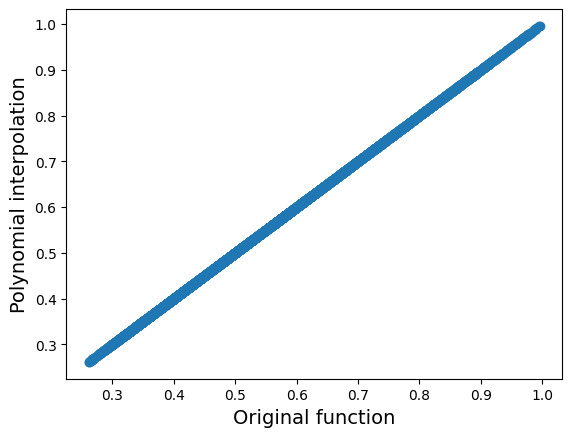

In [9]:
yy_test = runge(xx_test)
plt.scatter(yy_test, yy_poly)
plt.xlabel("Original function", fontsize=14)
plt.ylabel("Polynomial interpolation", fontsize=14);

Typically we want to evaluate the polynomial on hundreds of thousands to millions of query points.
The size of the evaluation problem depends on the cardinality of the multi-index set (which is problem dependent)
as well as the number of query points.

Below is an illustration how the cardinality of the set grows as a function of spatial dimension $m$, polynomial degree $n$, and $l_p$-degree $p$:

![title](mi-size.png)

...which directly translates to the time it takes to evaluate, say 100'000 query points as shown below

![title](timing.png)

## Newton polynomials evaluation: Behind the scene

The Newton monomials matrix is constructed element-wise by computing the Newton monomials at each query point:
$$
\mathcal{N}_{\boldsymbol{\alpha}^{(i)}} (\boldsymbol{x}^{(k)}) = \prod_{l = 1}^{m} \prod_{j = 1}^{\alpha^{(i)}_l} \left( x^{(k)}_l - p_{j, l} \right).
$$
where $p_{j, l}$, $n_{\mathrm{max}}$, $m$ are the generating points of the interpolation grid, the maximum degree in any given dimension, and the spatial dimension of the polynomial, respectively.

This is done in two main steps:
- create a chained product "look-up" matrix with respect to the query point.
- combined elements of the product "look-up" matrix according to the multi-index set to fill in the entry of the monomials matrix.

The product "look-up" matrix for a given query point $\boldsymbol{x}^{(k)} = \left( x^{(k)}_1, \ldots, x^{(k)}_m \right)$ is as follows:

$$
\mathbf{A} = \begin{bmatrix}
1.0 &
1.0 & 
\cdots & 
1.0 \\
(x^{k}_1 - p_{1, 1}) &
(x^{k}_2 - p_{1, 2}) & 
\cdots & 
(x^{k}_m - p_{1, m}) \\
(x^{k}_1 - p_{1, 1}) (x^{k}_1 - p_{2, 1}) &
(x^{k}_2 - p_{1, 2}) (x^{k}_2 - p_{2, 2}) & 
\cdots & 
(x^{k}_m - p_{1, m}) (x^{k}_m - p_{2, m}) \\
\vdots & \vdots & \ddots & \vdots \\
\prod_{j = 1}^{n_{\mathrm{max}}} (x^{k}_1 - p_{j, 1}) & 
\prod_{j = 1}^{n_{\mathrm{max}}} (x^{k}_1 - p_{j, 2}) & 
\cdots &
\prod_{j = 1}^{n_{\mathrm{max}}} (x^{k}_m - p_{j, m}) \\
\end{bmatrix}
$$
The size of this matrix is $(n_{\mathrm{max}} + 1) \times m$.,

Because the product "look-up" matrix has been precomputed for a given query point,
to compute $\mathcal{N}_{\boldsymbol{\alpha}^{(i)}} (\boldsymbol{x}^{(k)})$ for $\boldsymbol{\alpha}^{(i)} = \left( \alpha^{(i)}_1, \ldots, \alpha^{(i)}_m \right)$
we take the following product:
$$
\mathcal{N}_{\boldsymbol{\alpha}^{(i)}} (\boldsymbol{x}^{(k)}) = a_{\alpha^{(i)}_1 + 1, 1} \cdot \ldots \cdot a_{\alpha^{(i)}_m + 1, m}  
$$
Each row of the Newton monomials matrix consists of $N$ (one for each multi-index element) of $\mathcal{N}_{\boldsymbol{\alpha}^{(i)}} (\boldsymbol{x}^{(k)})$'s evaluated at $\boldsymbol{x}^{(k)}$.

Once this matrix has been constructed, multiply it with the corresponding $N \times 1$ Newton polynomial coefficients to obtain the polynomial values at the $K$ query points.

$$
\begin{bmatrix}
\mathcal{N}_{\boldsymbol{\alpha}^{(1)}} (\boldsymbol{x}^{(1)}) &
\mathcal{N}_{\boldsymbol{\alpha}^{(2)}} (\boldsymbol{x}^{(1)}) & 
\cdots & 
\mathcal{N}_{\boldsymbol{\alpha}^{(N)}} (\boldsymbol{x}^{(1)}) \\
\mathcal{N}_{\boldsymbol{\alpha}^{(1)}} (\boldsymbol{x}^{(2)}) &
\mathcal{N}_{\boldsymbol{\alpha}^{(2)}} (\boldsymbol{x}^{(2)}) & 
\cdots & 
\mathcal{N}_{\boldsymbol{\alpha}^{(N)}} (\boldsymbol{x}^{(2)}) \\
\vdots & \vdots & \ddots & \vdots \\
\mathcal{N}_{\boldsymbol{\alpha}^{(1)}} (\boldsymbol{x}^{(K)}) &
\mathcal{N}_{\boldsymbol{\alpha}^{(2)}} (\boldsymbol{x}^{(K)}) & 
\cdots & 
\mathcal{N}_{\boldsymbol{\alpha}^{(N)}} (\boldsymbol{x}^{(K)}) \\
\end{bmatrix}
\begin{bmatrix}
c_{\boldsymbol{\alpha}^{(1)}} \\
c_{\boldsymbol{\alpha}^{(2)}} \\
\vdots \\
c_{\boldsymbol{\alpha}^{(N)}} \\
\end{bmatrix}
$$

## Current efforts to accelerate

- Some functionalities involving loops such as the computation of the product "look-up matrix" and the monomials matrix are compiled with the help of `Numba`.
- Simple parallel evaluations using the `multiprocessing` module for multiple batches of query points.

_Could GPU be of help accelerating the evaluation of Newton polynomials in Minterpy?_

**Note**: In an interpolation setting, we obtain the set of $c_{N, \boldsymbol{\alpha}}$'s from the transformation of function values at the (unisolvent) interpolation grid points (i.e., the _Lagrange_ coefficients) to the Newton coefficients. In the present context, we take $c_{N, \boldsymbol{\alpha}}$ as given and focus on the problem of evaluating a Newton polynomials on a set of query points.